In [99]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model


from tensorflow.keras.applications.resnet50 import ResNet50

from tensorflow.keras.applications.xception import Xception

from tensorflow.keras.applications import DenseNet201

from tensorflow.keras.applications.vgg19 import VGG19

from sklearn.metrics import precision_score, accuracy_score, mean_absolute_error, mean_squared_error, confusion_matrix, classification_report, recall_score, f1_score


from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import seaborn as sns
np.random.seed(42)
tf.random.set_seed(42)
import os
import cv2

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17382488156257873217
xla_global_id: -1
]


In [6]:
train_path="./Dataset/train"
test_path="./Dataset/testing"
val_path="./Dataset/Valid"

In [7]:
x_train=[]
for folder in os.listdir(train_path):
    sub_path=train_path+"/"+folder
    for img in os.listdir(sub_path):
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(80,80))
        x_train.append(img_arr)
x_test=[]
for folder in os.listdir(test_path):
    sub_path=test_path+"/"+folder
    for img in os.listdir(sub_path):
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(80,80))
        x_test.append(img_arr)
x_val=[]
for folder in os.listdir(val_path):
    sub_path=val_path+"/"+folder
    for img in os.listdir(sub_path):
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(80,80))
        x_val.append(img_arr)

In [8]:
train_x=np.array(x_train)
test_x=np.array(x_test)
val_x=np.array(x_val)

In [9]:
train_x=train_x/255.0
test_x=test_x/255.0
val_x=val_x/255.0

In [10]:
train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255)

In [11]:
training_set = train_datagen.flow_from_directory(train_path,
                                                target_size = (80, 80),
                                                batch_size = 16,
                                                class_mode = 'categorical')
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (80, 80),
                                            batch_size = 16,
                                            class_mode = 'categorical')
val_set = val_datagen.flow_from_directory(val_path,
                                        target_size = (80, 80),
                                        batch_size = 16,
                                        class_mode = 'categorical')

Found 2350 images belonging to 2 classes.
Found 738 images belonging to 2 classes.
Found 641 images belonging to 2 classes.


In [12]:
train_y=training_set.classes
test_y=test_set.classes
val_y=val_set.classes


In [13]:
training_set.class_indices

{'Normal': 0, 'Osteoarthritis': 1}

In [14]:
train_y.shape,test_y.shape,val_y.shape

((2350,), (738,), (641,))

In [15]:
dense_net = DenseNet201(input_shape = (80, 80, 3), weights='imagenet', include_top=False)
#do not train the pre-trained layers of densenett201
for layer in dense_net.layers:
    layer.trainable = False
x = Flatten()(dense_net.output)

In [16]:
#adding output layer.Sigmoid classifier is used as it is binary classification
x = Dropout(0.5)(x)
prediction = Dense(2, activation='sigmoid')(x)

model = Model(inputs=dense_net.input, outputs=prediction)

In [17]:
# view the structure of the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 80, 80, 3)]          0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 86, 86, 3)            0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 40, 40, 64)           9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 40, 40, 64)           256       ['conv1/conv[0][0]']      

In [19]:
model.compile(
 loss='sparse_categorical_crossentropy',
 optimizer="adam",
 metrics=['accuracy']
)

In [20]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
checkpoint = ModelCheckpoint('./Model/DenseNet Model/weights-imporvement-{epoch:02d}-{val_accuracy:.2f}.hdf5',
                            monitor = 'val_accuracy', save_best_only = True, verbose = 1)
early_stop=EarlyStopping(monitor='val_loss',mode='min',verbose=1, patience=5)
#Early stopping to avoid overfitting of model
log_csv = CSVLogger('./Model/DenseNet Model/my_log.csv', separator=',', append = False)

In [21]:
# fit the model
history = model.fit(
 train_x,
 train_y,
 validation_data=(val_x,val_y),
 epochs=10,
 callbacks=[checkpoint, log_csv],
 batch_size=16,shuffle=True)

Epoch 1/10
147/147 [==============================] - ETA: 0s - loss: 0.6635 - accuracy: 0.7694
Epoch 1: val_accuracy improved from -inf to 0.88768, saving model to ./Model/DenseNet Model\weights-imporvement-01-0.89.hdf5


C:\Users\Hp\anaconda3\envs\latest\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


147/147 [==============================] - 149s 842ms/step - loss: 0.6635 - accuracy: 0.7694 - val_loss: 0.2834 - val_accuracy: 0.8877
Epoch 2/10
147/147 [==============================] - ETA: 0s - loss: 0.4936 - accuracy: 0.8209
Epoch 2: val_accuracy improved from 0.88768 to 0.89704, saving model to ./Model/DenseNet Model\weights-imporvement-02-0.90.hdf5
147/147 [==============================] - 116s 790ms/step - loss: 0.4936 - accuracy: 0.8209 - val_loss: 0.2506 - val_accuracy: 0.8970
Epoch 3/10
147/147 [==============================] - ETA: 0s - loss: 0.5026 - accuracy: 0.8191
Epoch 3: val_accuracy did not improve from 0.89704
147/147 [==============================] - 112s 764ms/step - loss: 0.5026 - accuracy: 0.8191 - val_loss: 0.2639 - val_accuracy: 0.8970
Epoch 4/10
147/147 [==============================] - ETA: 0s - loss: 0.4848 - accuracy: 0.8272
Epoch 4: val_accuracy did not improve from 0.89704
147/147 [==============================] - 113s 771ms/step - loss: 0.4848 - a

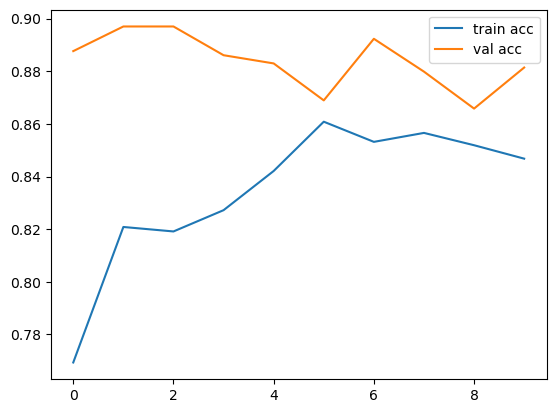

In [22]:
import matplotlib.pyplot as plt

# accuracies
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.savefig('dense_net-acc-rps-1.png')
plt.show()


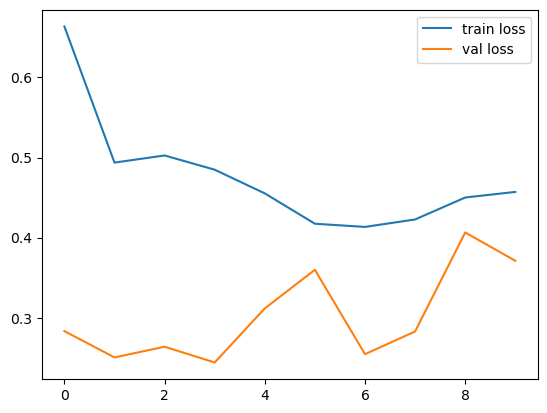

In [23]:
# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.savefig('dense_net-loss-rps-1.png')
plt.show()

In [24]:
print("[Loss, Accuracy] = ", model.evaluate(test_x,test_y,batch_size=16))

47/47 [==============================] - 28s 605ms/step - loss: 0.3672 - accuracy: 0.8780
[Loss, Accuracy] =  [0.36720940470695496, 0.8780487775802612]


In [32]:
model.save('../Model/DenseNet Model/dense_net_model.h5')

In [33]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
import numpy as np

In [34]:
#predict
y_pred=model.predict(test_x)
y_pred=np.argmax(y_pred,axis=1)

24/24 [==============================] - 36s 1s/step


In [35]:
#get classification report
print(classification_report(y_pred,test_y))

              precision    recall  f1-score   support

           0       0.70      0.89      0.78       180
           1       0.96      0.87      0.92       558

    accuracy                           0.88       738
   macro avg       0.83      0.88      0.85       738
weighted avg       0.90      0.88      0.88       738



In [38]:
#get confusion matrix
print(confusion_matrix(y_pred,test_y))

[[160  20]
 [ 70 488]]


array([[160,  20],
       [ 70, 488]], dtype=int64)

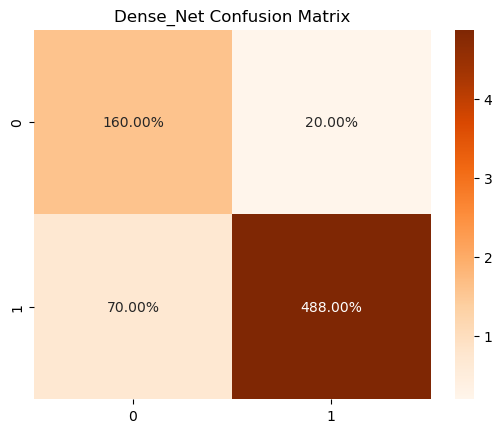

In [103]:
Den = confusion_matrix(y_pred,test_y)
sns.heatmap(Den/100, annot = True, fmt = '0.2%', cmap = 'Oranges')
plt.title("Dense_Net Confusion Matrix")
Den 

In [104]:
DN_acc = accuracy_score(y_pred,test_y)
DN_precision = precision_score(y_pred,test_y)
DN_recall = recall_score(y_pred,test_y)
DN_f1 = f1_score(y_pred,test_y)
print("The accuracy for Dense_Net is", DN_acc)
print("The classification report using XGBoost is:", DN_acc)
print(classification_report(y_pred,test_y))

The accuracy for Dense_Net is 0.8780487804878049
The classification report using XGBoost is: 0.8780487804878049
              precision    recall  f1-score   support

           0       0.70      0.89      0.78       180
           1       0.96      0.87      0.92       558

    accuracy                           0.88       738
   macro avg       0.83      0.88      0.85       738
weighted avg       0.90      0.88      0.88       738



### ResNet Model

In [66]:

# Load resnet model with pre-trained weights
resnet_model = ResNet50(input_shape=(80, 80, 3), weights='imagenet', include_top=False)

# Do not train the pre-trained layers of Xception
for layer in resnet_model.layers:
    layer.trainable = False

# Flatten the output of the Xception model
x1 = Flatten()(resnet_model.output)

# Adding dropout layer for regularization
x1 = Dropout(0.5)(x1)

# Adding the output layer with sigmoid activation for binary classification
predictions1 = Dense(2, activation='sigmoid')(x1)

# Create the final model with variable name model1
model1 = Model(inputs=resnet_model.input, outputs=predictions1)

# View the structure of the model
model1.summary()


Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 80, 80, 3)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 86, 86, 3)            0         ['input_10[0][0]']            
                                                                                                  
 conv1_conv (Conv2D)         (None, 40, 40, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 40, 40, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [47]:
model1.compile(
 loss='sparse_categorical_crossentropy',
 optimizer="adam",
 metrics=['accuracy']
)

In [48]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
checkpoint1 = ModelCheckpoint('./Model1/ResNet Model/weights-imporvement-{epoch:02d}-{val_accuracy:.2f}.hdf5',
                            monitor = 'val_accuracy', save_best_only = True, verbose = 1)
early_stop1=EarlyStopping(monitor='val_loss',mode='min',verbose=1, patience=5)
#Early stopping to avoid overfitting of model
log_csv1 = CSVLogger('./Model1/ResNet Model/my_log.csv1', separator=',', append = False)

In [49]:
# fit the model
history1 = model1.fit(
 train_x,
 train_y,
 validation_data=(val_x,val_y),
 epochs=10,
 callbacks=[checkpoint1, log_csv1],
 batch_size=16,shuffle=True)

Epoch 1/10
147/147 [==============================] - ETA: 0s - loss: 0.7555 - accuracy: 0.6170
Epoch 1: val_accuracy improved from -inf to 0.67239, saving model to ./Model1/ResNet Model\weights-imporvement-01-0.67.hdf5


C:\Users\Hp\anaconda3\envs\latest\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


147/147 [==============================] - 117s 725ms/step - loss: 0.7555 - accuracy: 0.6170 - val_loss: 0.6259 - val_accuracy: 0.6724
Epoch 2/10
147/147 [==============================] - ETA: 0s - loss: 0.6820 - accuracy: 0.6336
Epoch 2: val_accuracy improved from 0.67239 to 0.72699, saving model to ./Model1/ResNet Model\weights-imporvement-02-0.73.hdf5
147/147 [==============================] - 97s 657ms/step - loss: 0.6820 - accuracy: 0.6336 - val_loss: 0.4672 - val_accuracy: 0.7270
Epoch 3/10
147/147 [==============================] - ETA: 0s - loss: 0.6393 - accuracy: 0.6336
Epoch 3: val_accuracy improved from 0.72699 to 0.73635, saving model to ./Model1/ResNet Model\weights-imporvement-03-0.74.hdf5
147/147 [==============================] - 84s 575ms/step - loss: 0.6393 - accuracy: 0.6336 - val_loss: 0.4693 - val_accuracy: 0.7363
Epoch 4/10
147/147 [==============================] - ETA: 0s - loss: 0.6685 - accuracy: 0.6468
Epoch 4: val_accuracy did not improve from 0.73635
147/

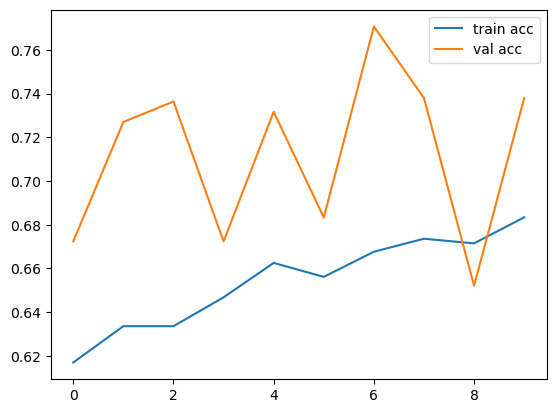

In [52]:
# accuracies
plt.plot(history1.history['accuracy'], label='train acc')
plt.plot(history1.history['val_accuracy'], label='val acc')
plt.legend()
plt.savefig('res_net-acc-rps-1.png')
plt.show()

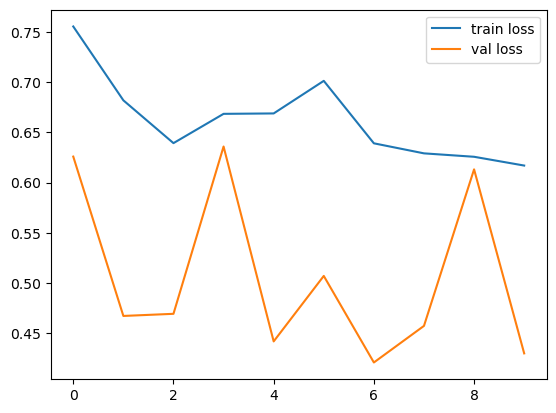

In [53]:
# loss
plt.plot(history1.history['loss'], label='train loss')
plt.plot(history1.history['val_loss'], label='val loss')
plt.legend()
plt.savefig('res_net-loss-rps-1.png')
plt.show()

In [54]:
print("[Loss, Accuracy] = ", model1.evaluate(test_x,test_y,batch_size=16))

47/47 [==============================] - 21s 449ms/step - loss: 0.4451 - accuracy: 0.7371
[Loss, Accuracy] =  [0.4451294243335724, 0.7371273636817932]


In [56]:
model.save('../Model1/ResNet Model/resnet_net_model.h5')

In [57]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
import numpy as np

In [58]:
#predict
y_pred1=model1.predict(test_x)
y_pred1=np.argmax(y_pred1,axis=1)

24/24 [==============================] - 20s 766ms/step


In [59]:
#get classification report
print(classification_report(y_pred1,test_y))

              precision    recall  f1-score   support

           0       0.23      0.75      0.36        72
           1       0.96      0.74      0.83       666

    accuracy                           0.74       738
   macro avg       0.60      0.74      0.60       738
weighted avg       0.89      0.74      0.79       738



In [106]:
#get confusion matrix
print(confusion_matrix(y_pred1,test_y))

[[ 54  18]
 [176 490]]


array([[ 54,  18],
       [176, 490]], dtype=int64)

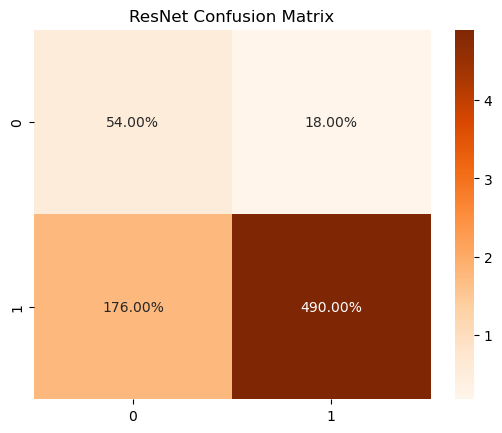

In [105]:
Res = confusion_matrix(y_pred1,test_y)
sns.heatmap(Res/100, annot = True, fmt = '0.2%', cmap = 'Oranges')
plt.title("ResNet Confusion Matrix")
Res

In [107]:
RN_acc = accuracy_score(y_pred1,test_y)
RN_precision = precision_score(y_pred1,test_y)
RN_recall = recall_score(y_pred1,test_y)
RN_f1 = f1_score(y_pred1,test_y)
print("The accuracy for ResNet is", RN_acc)
print("The classification report using ResNet is:", RN_acc)
print(classification_report(y_pred1,test_y))

The accuracy for ResNet is 0.7371273712737128
The classification report using ResNet is: 0.7371273712737128
              precision    recall  f1-score   support

           0       0.23      0.75      0.36        72
           1       0.96      0.74      0.83       666

    accuracy                           0.74       738
   macro avg       0.60      0.74      0.60       738
weighted avg       0.89      0.74      0.79       738



### Xception Model

In [108]:
# Load Xception model with pre-trained weights
xception_model = Xception(input_shape=(80, 80, 3), weights='imagenet', include_top=False)

# Do not train the pre-trained layers of Xception
for layer in xception_model.layers:
    layer.trainable = False

# Flatten the output of the Xception model
x2 = Flatten()(xception_model.output)

# Adding dropout layer for regularization
x2 = Dropout(0.5)(x2)

# Adding the output layer with sigmoid activation for binary classification
predictions2 = Dense(2, activation='sigmoid')(x2)

# Create the final model with variable name model1
model2 = Model(inputs=xception_model.input, outputs=predictions2)

# View the structure of the model
model2.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_14 (InputLayer)       [(None, 80, 80, 3)]          0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 39, 39, 32)           864       ['input_14[0][0]']            
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 39, 39, 32)           128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 39, 39, 32)           0         ['block1_conv1_bn[0][0]

In [71]:
model2.compile(
 loss='sparse_categorical_crossentropy',
 optimizer="adam",
 metrics=['accuracy']
)

In [68]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
checkpoint2 = ModelCheckpoint('./Model2/Xception Model/weights-imporvement-{epoch:02d}-{val_accuracy:.2f}.hdf5',
                            monitor = 'val_accuracy', save_best_only = True, verbose = 1)
early_stop2=EarlyStopping(monitor='val_loss',mode='min',verbose=1, patience=5)
#Early stopping to avoid overfitting of model
log_csv2 = CSVLogger('./Model2/Xception Model/my_log.csv2', separator=',', append = False)

In [73]:
# fit the model
history2 = model2.fit(
 train_x,
 train_y,
 validation_data=(val_x,val_y),
 epochs=10,
 callbacks=[checkpoint2, log_csv2],
 batch_size=16,shuffle=True)

Epoch 1/10
147/147 [==============================] - ETA: 0s - loss: 0.5293 - accuracy: 0.7647
Epoch 1: val_accuracy improved from -inf to 0.82059, saving model to ./Model2/Xception Model\weights-imporvement-01-0.82.hdf5


C:\Users\Hp\anaconda3\envs\latest\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


147/147 [==============================] - 95s 606ms/step - loss: 0.5293 - accuracy: 0.7647 - val_loss: 0.4034 - val_accuracy: 0.8206
Epoch 2/10
147/147 [==============================] - ETA: 0s - loss: 0.3700 - accuracy: 0.8306
Epoch 2: val_accuracy improved from 0.82059 to 0.84243, saving model to ./Model2/Xception Model\weights-imporvement-02-0.84.hdf5
147/147 [==============================] - 89s 606ms/step - loss: 0.3700 - accuracy: 0.8306 - val_loss: 0.3790 - val_accuracy: 0.8424
Epoch 3/10
147/147 [==============================] - ETA: 0s - loss: 0.3524 - accuracy: 0.8370
Epoch 3: val_accuracy improved from 0.84243 to 0.85179, saving model to ./Model2/Xception Model\weights-imporvement-03-0.85.hdf5
147/147 [==============================] - 95s 646ms/step - loss: 0.3524 - accuracy: 0.8370 - val_loss: 0.3694 - val_accuracy: 0.8518
Epoch 4/10
147/147 [==============================] - ETA: 0s - loss: 0.3658 - accuracy: 0.8362
Epoch 4: val_accuracy did not improve from 0.85179
1

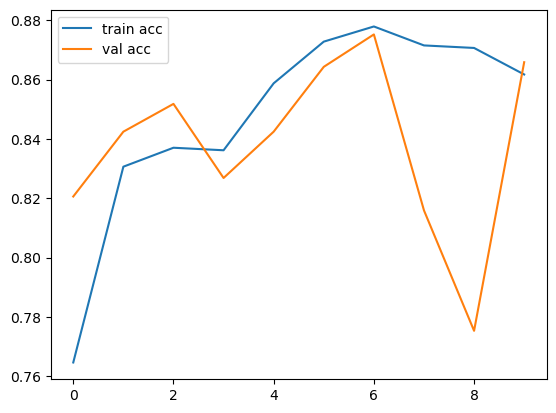

In [74]:
# accuracies
plt.plot(history2.history['accuracy'], label='train acc')
plt.plot(history2.history['val_accuracy'], label='val acc')
plt.legend()
plt.savefig('xception-acc-rps-1.png')
plt.show()

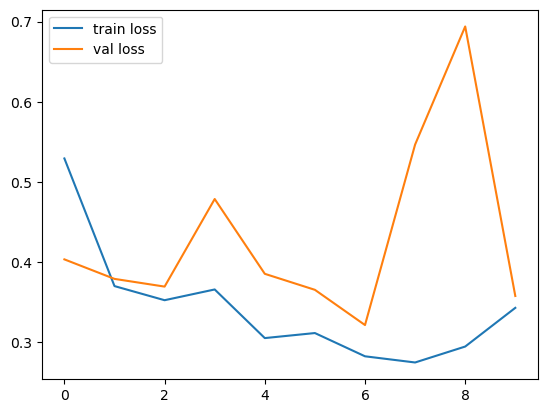

In [75]:
# loss
plt.plot(history2.history['loss'], label='train loss')
plt.plot(history2.history['val_loss'], label='val loss')
plt.legend()
plt.savefig('xception-loss-rps-1.png')
plt.show()

In [76]:
print("[Loss, Accuracy] = ", model2.evaluate(test_x,test_y,batch_size=16))

47/47 [==============================] - 22s 461ms/step - loss: 0.3677 - accuracy: 0.8550
[Loss, Accuracy] =  [0.367692232131958, 0.8550135493278503]


In [77]:
model.save('../Model2/Xception Model/xception_model.h5')

In [78]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
import numpy as np

In [79]:
#predict
y_pred2=model2.predict(test_x)
y_pred2=np.argmax(y_pred2,axis=1)

24/24 [==============================] - 22s 845ms/step


In [80]:
#get classification report
print(classification_report(y_pred2,test_y))

              precision    recall  f1-score   support

           0       0.73      0.79      0.76       215
           1       0.91      0.88      0.90       523

    accuracy                           0.86       738
   macro avg       0.82      0.83      0.83       738
weighted avg       0.86      0.86      0.86       738



In [81]:
#get confusion matrix
print(confusion_matrix(y_pred2,test_y))

[[169  46]
 [ 61 462]]


array([[169,  46],
       [ 61, 462]], dtype=int64)

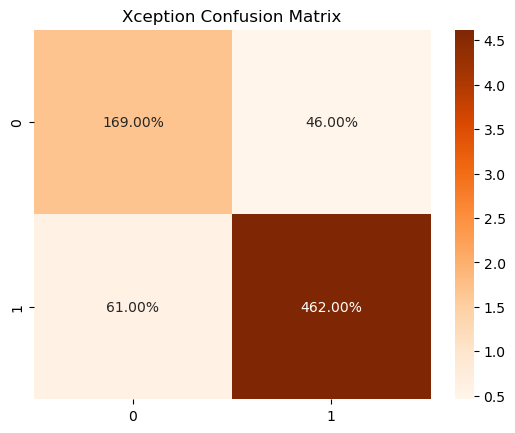

In [109]:
X_cm = confusion_matrix(y_pred2,test_y)
sns.heatmap(X_cm/100, annot = True, fmt = '0.2%', cmap = 'Oranges')
plt.title("Xception Confusion Matrix")
X_cm 

In [110]:
X_acc = accuracy_score(y_pred2,test_y)
X_precision = precision_score(y_pred2,test_y)
X_recall = recall_score(y_pred2,test_y)
X_f1 = f1_score(y_pred2,test_y)
print("The accuracy for Xception is", X_acc)
print("The classification report using Xception is:", X_acc)
print(classification_report(y_pred2,test_y))

The accuracy for Xception is 0.8550135501355014
The classification report using Xception is: 0.8550135501355014
              precision    recall  f1-score   support

           0       0.73      0.79      0.76       215
           1       0.91      0.88      0.90       523

    accuracy                           0.86       738
   macro avg       0.82      0.83      0.83       738
weighted avg       0.86      0.86      0.86       738



### VGG19

In [86]:
# Load VGG19 model with pre-trained weights
vgg19_model = VGG19(input_shape=(80, 80, 3), weights='imagenet', include_top=False)

# Do not train the pre-trained layers of VGG19
for layer in vgg19_model.layers:
    layer.trainable = False

# Flatten the output of the VGG19 model
x3 = Flatten()(vgg19_model.output)

# Adding dropout layer for regularization
x3 = Dropout(0.5)(x3)

# Adding the output layer with sigmoid activation for binary classification
predictions3 = Dense(2, activation='sigmoid')(x3)

# Create the final model with variable name model1
model3 = Model(inputs=vgg19_model.input, outputs=predictions3)


In [87]:
# View the structure of the model
model3.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 80, 80, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 80, 80, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 80, 80, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 40, 40, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 40, 40, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 40, 40, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 20, 20, 128)       0  

In [88]:
model3.compile(
 loss='sparse_categorical_crossentropy',
 optimizer="adam",
 metrics=['accuracy']
)

In [89]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
checkpoint3 = ModelCheckpoint('./Model3/VGG19 Model/weights-imporvement-{epoch:02d}-{val_accuracy:.2f}.hdf5',
                            monitor = 'val_accuracy', save_best_only = True, verbose = 1)
early_stop3=EarlyStopping(monitor='val_loss',mode='min',verbose=1, patience=5)
#Early stopping to avoid overfitting of model
log_csv3 = CSVLogger('./Model3/VGG19 Model/my_log.csv3', separator=',', append = False)

In [90]:
# fit the model
history3 = model3.fit(
 train_x,
 train_y,
 validation_data=(val_x,val_y),
 epochs=10,
 callbacks=[checkpoint3, log_csv3],
 batch_size=16,shuffle=True)

Epoch 1/10
147/147 [==============================] - ETA: 0s - loss: 0.5672 - accuracy: 0.6736
Epoch 1: val_accuracy improved from -inf to 0.70827, saving model to ./Model3/VGG19 Model\weights-imporvement-01-0.71.hdf5


C:\Users\Hp\anaconda3\envs\latest\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


147/147 [==============================] - 297s 2s/step - loss: 0.5672 - accuracy: 0.6736 - val_loss: 0.4301 - val_accuracy: 0.7083
Epoch 2/10
147/147 [==============================] - ETA: 0s - loss: 0.4937 - accuracy: 0.7149
Epoch 2: val_accuracy improved from 0.70827 to 0.78471, saving model to ./Model3/VGG19 Model\weights-imporvement-02-0.78.hdf5
147/147 [==============================] - 289s 2s/step - loss: 0.4937 - accuracy: 0.7149 - val_loss: 0.3920 - val_accuracy: 0.7847
Epoch 3/10
147/147 [==============================] - ETA: 0s - loss: 0.4658 - accuracy: 0.7472
Epoch 3: val_accuracy improved from 0.78471 to 0.84711, saving model to ./Model3/VGG19 Model\weights-imporvement-03-0.85.hdf5
147/147 [==============================] - 287s 2s/step - loss: 0.4658 - accuracy: 0.7472 - val_loss: 0.3578 - val_accuracy: 0.8471
Epoch 4/10
147/147 [==============================] - ETA: 0s - loss: 0.4505 - accuracy: 0.7528
Epoch 4: val_accuracy did not improve from 0.84711
147/147 [====

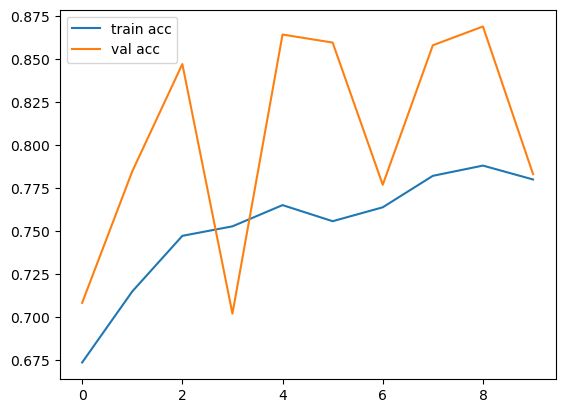

In [91]:
# accuracies
plt.plot(history3.history['accuracy'], label='train acc')
plt.plot(history3.history['val_accuracy'], label='val acc')
plt.legend()
plt.savefig('VGG19-acc-rps-1.png')
plt.show()

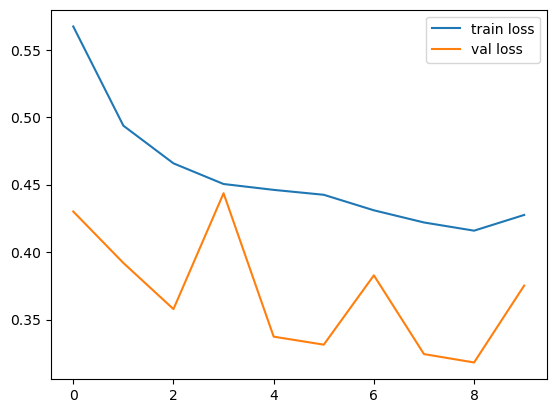

In [92]:
# loss
plt.plot(history3.history['loss'], label='train loss')
plt.plot(history3.history['val_loss'], label='val loss')
plt.legend()
plt.savefig('VGG19-loss-rps-1.png')
plt.show()

In [93]:
print("[Loss, Accuracy] = ", model3.evaluate(test_x,test_y,batch_size=16))

47/47 [==============================] - 70s 1s/step - loss: 0.3868 - accuracy: 0.7846
[Loss, Accuracy] =  [0.38682523369789124, 0.7845528721809387]


In [94]:
model.save('../Model3/VGG19 Model/vgg19_model.h5')

In [95]:
#predict
y_pred3=model3.predict(test_x)
y_pred3=np.argmax(y_pred3,axis=1)

24/24 [==============================] - 69s 3s/step


In [96]:
#get classification report
print(classification_report(y_pred3,test_y))

              precision    recall  f1-score   support

           0       0.38      0.84      0.53       105
           1       0.97      0.78      0.86       633

    accuracy                           0.78       738
   macro avg       0.67      0.81      0.69       738
weighted avg       0.88      0.78      0.81       738



In [97]:
#get confusion matrix
print(confusion_matrix(y_pred3,test_y))

[[ 88  17]
 [142 491]]


array([[ 88,  17],
       [142, 491]], dtype=int64)

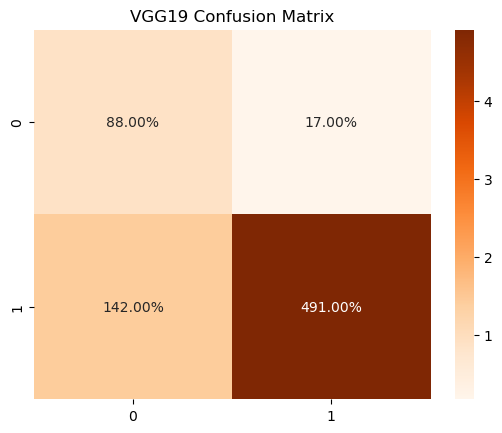

In [111]:
VGG_cm = confusion_matrix(y_pred3,test_y)
sns.heatmap(VGG_cm/100, annot = True, fmt = '0.2%', cmap = 'Oranges')
plt.title("VGG19 Confusion Matrix")
VGG_cm 

In [101]:
VGG_acc = accuracy_score(y_pred3,test_y)
VGG_precision = precision_score(y_pred3,test_y)
VGG_recall = recall_score(y_pred3,test_y)
VGG_f1 = f1_score(y_pred3,test_y)
print("The accuracy for VGG19 is", VGG_acc)
print("The classification report using VGG19 is:", VGG_acc)
print(classification_report(y_pred3,test_y))

The accuracy for VGG19 is 0.7845528455284553
The classification report using VGG19 is: 0.7845528455284553
              precision    recall  f1-score   support

           0       0.38      0.84      0.53       105
           1       0.97      0.78      0.86       633

    accuracy                           0.78       738
   macro avg       0.67      0.81      0.69       738
weighted avg       0.88      0.78      0.81       738



## Performance of the Model


In [113]:
## Algorithm Comparison 
models = pd.DataFrame({
    'Model':['Dense_Net', 'ResNet', 'Xception', 'VGG19'],
    'Accuracy' :[ DN_acc, RN_acc,  X_acc, VGG_acc],
    'Precision' :[ DN_precision, RN_precision , X_precision, VGG_precision ],
    'Recall' :[ DN_recall, RN_recall,  X_recall, VGG_recall ],
    'F1 Score' :[ DN_f1, RN_f1,  X_f1, VGG_f1]
})
models = models.sort_values(by='Accuracy', ascending=False)


In [114]:
models

,Model,Accuracy,Precision,Recall,F1 Score
0,Dense_Net,0.878049,0.960630,0.874552,0.915572
2,Xception,0.855014,0.909449,0.883365,0.896217
3,VGG19,0.784553,0.966535,0.775671,0.860649
1,ResNet,0.737127,0.964567,0.735736,0.834753
